In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base= automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/wr/cxxdrkjs7fx82z7ww61l665r0000gn/T/ipykernel_95666/3835783893.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()
print(f'recent date is: {recent_date}')

recent date is: 2017-08-23


Text(0.5, 1.0, 'Precipitation Over the Last 12 Months')

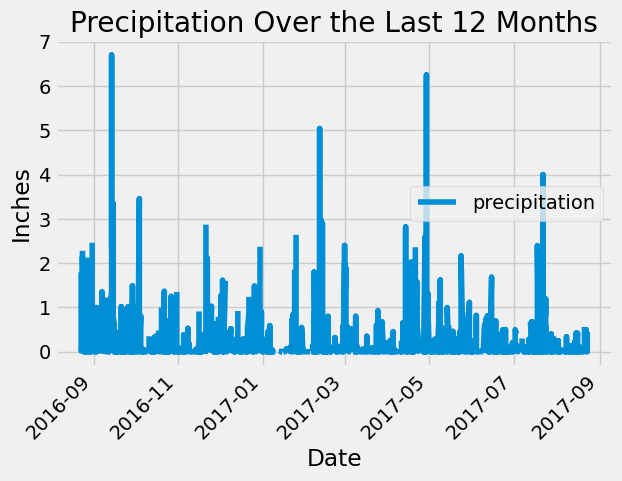

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

last_12_months = (pd.to_datetime(recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= last_12_months).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("date")


# Use Pandas Plotting with Matplotlib to plot the data
# Convert 'date' column to datetime format for accurate plotting
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

precipitation_df.plot(x="date", y="precipitation", rot=45)

# Labeling the plot
plt.xlabel("Date")  
plt.ylabel("Inches")  
plt.title("Precipitation Over the Last 12 Months") 



In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,date,precipitation
count,2230,2021.000000
mean,2017-02-16 05:31:15.874439424,0.177279
min,2016-08-23 00:00:00,0.000000
25%,2016-11-18 00:00:00,0.000000
50%,2017-02-14 12:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.461190


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station))[0]
total_stations

(9,)

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)

# Query to find stations with the most rows
stations_count = session.query(
    measurement.station,
    func.count(measurement.id).label('observation_count')
).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()

# Print the results
for station, observation_count in stations_count:
    print(f'Station ID: {station}, Observation Count: {observation_count}')




# List the stations and their counts in descending order.


Station ID: USC00519281, Observation Count: 2772
Station ID: USC00519397, Observation Count: 2724
Station ID: USC00513117, Observation Count: 2709
Station ID: USC00519523, Observation Count: 2669
Station ID: USC00516128, Observation Count: 2612
Station ID: USC00514830, Observation Count: 2202
Station ID: USC00511918, Observation Count: 1979
Station ID: USC00517948, Observation Count: 1372
Station ID: USC00518838, Observation Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = stations_count[0][0]

temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
    ).filter(measurement.station == most_active_station).all()

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

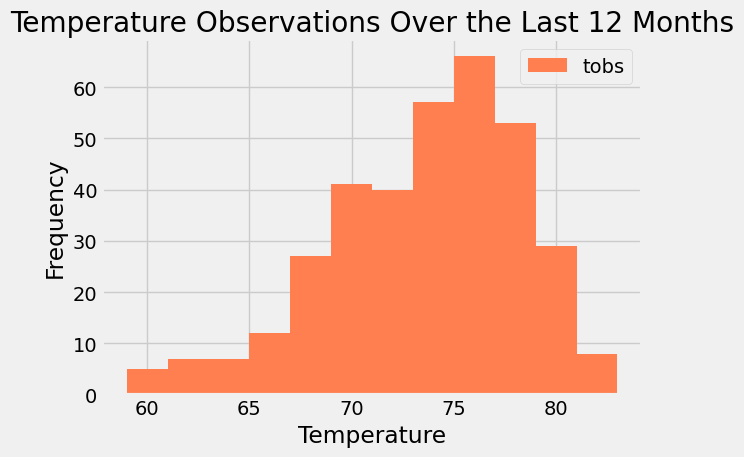

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement.tobs)\
    .filter(measurement.station == most_active_station)\
    .filter(measurement.date >= last_12_months).all()
# Convert the query results into a DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["tobs"])

# Plot the histogram with bins=12
tobs_df.plot.hist(bins=12, color="coral")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Observations Over the Last 12 Months")
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()